In [22]:
from common_functions import *
import pandas as pd
PATH = "datasets/Fifa"

fifa = load_housing_data(PATH, "fifa_data.csv")

In [23]:
fifa.head()
fifa = fifa.drop(["Unnamed: 0", "Photo", "ID", "Loaned From", "Contract Valid Until", "Loaned From", "Club Logo", "Joined"], axis=1)
fifa.info()
fifa['ST'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      18207 non-null  object 
 1   Age                       18207 non-null  int64  
 2   Nationality               18207 non-null  object 
 3   Flag                      18207 non-null  object 
 4   Overall                   18207 non-null  int64  
 5   Potential                 18207 non-null  int64  
 6   Club                      17966 non-null  object 
 7   Value                     18207 non-null  object 
 8   Wage                      18207 non-null  object 
 9   Special                   18207 non-null  int64  
 10  Preferred Foot            18159 non-null  object 
 11  International Reputation  18159 non-null  float64
 12  Weak Foot                 18159 non-null  float64
 13  Skill Moves               18159 non-null  float64
 14  Work R

61+2    705
60+2    695
59+2    688
63+2    667
64+2    666
       ... 
91+3      1
55+3      1
47+3      1
82+4      1
88+2      1
Name: ST, Length: 93, dtype: int64

In [24]:
def wealthToInt(column):
    column = column.str.replace('€', '')
    column = column.str.replace('K', '')
    column = column.str.replace('M', '000')
    column = pd.to_numeric(column)
    return column

array_wealth = ['Wage', 'Release Clause', 'Value']
for wealth in array_wealth:
    fifa[wealth] = fifa[wealth].transform(wealthToInt)

In [25]:
# Create dataset
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(fifa, test_size=0.2, random_state=42)

In [26]:
# Verify the error percentage between the train set and the overall
compare_props = pd.DataFrame({
    "Overall": fifa["Overall"].value_counts()/len(fifa),
    "Train_set": train_set["Overall"].value_counts()/len(train_set),
}).sort_index()
compare_props["%error"] = 100 * compare_props["Train_set"] / compare_props["Overall"] - 100
# compare_props

In [27]:
# Create copy of traning set 
fifa = train_set.copy()


In [28]:
# Correlation matrix
corr_matrix = fifa.corr()
print(corr_matrix["Potential"].sort_values(ascending= False))

Potential                   1.000000
Overall                     0.662475
Reactions                   0.512711
Wage                        0.490070
Composure                   0.441782
Special                     0.384202
International Reputation    0.375401
ShortPassing                0.371152
Value                       0.365761
Skill Moves                 0.359044
BallControl                 0.355369
Vision                      0.349788
LongPassing                 0.324409
Dribbling                   0.316814
ShotPower                   0.290221
Curve                       0.281802
LongShots                   0.267443
Volleys                     0.257757
Positioning                 0.247479
Finishing                   0.247431
Crossing                    0.247129
SprintSpeed                 0.234556
Acceleration                0.233525
FKAccuracy                  0.233027
Penalties                   0.226829
Agility                     0.221649
Stamina                     0.200869
H

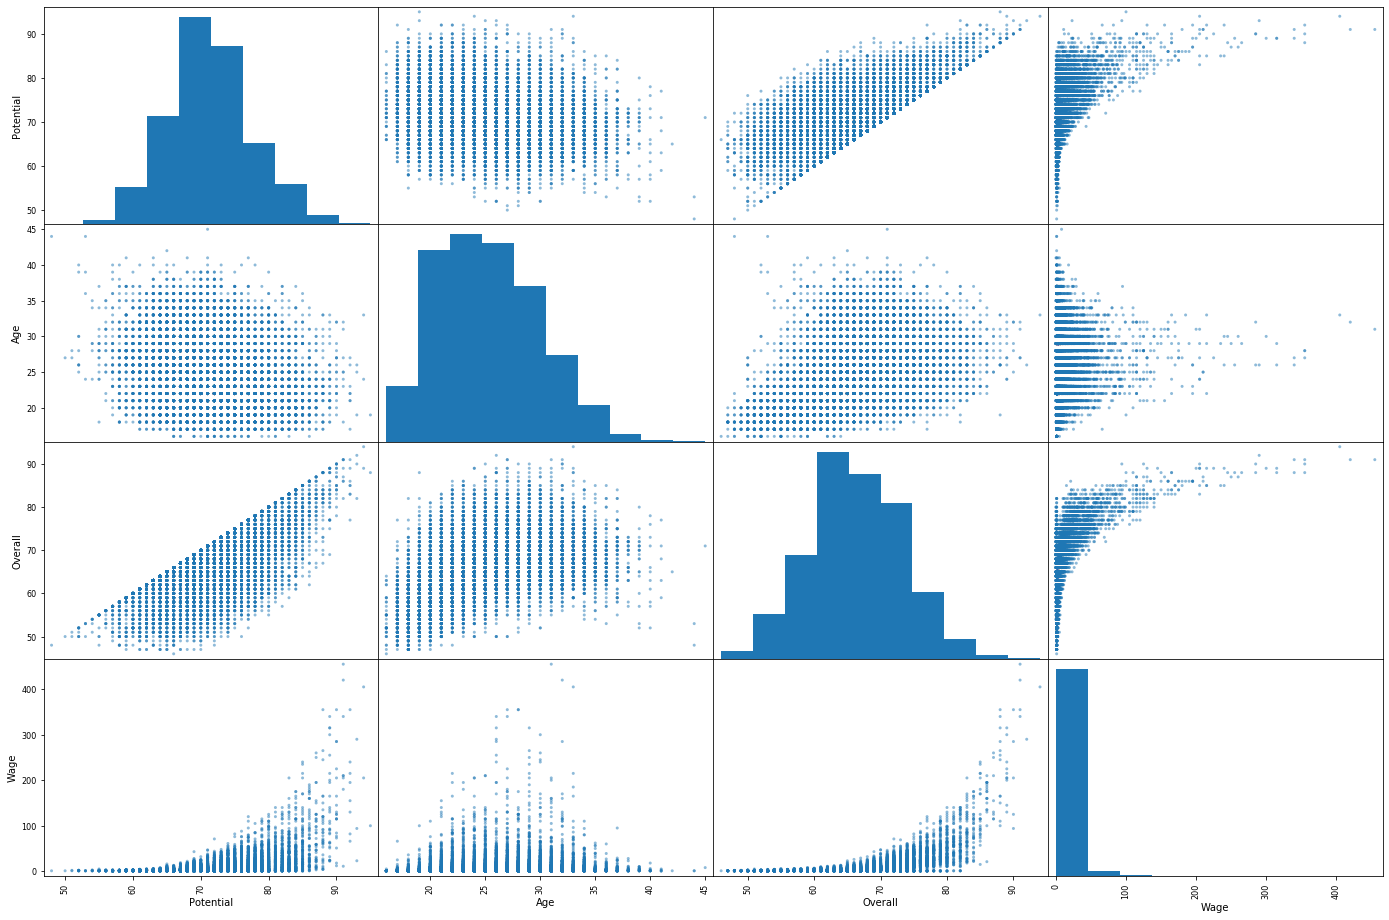

In [29]:
# Scattered matrixes to see correlations between columns
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

attributes = ["Potential", "Age", "Overall", "Wage"]
fig = scatter_matrix(fifa[attributes], figsize=(24, 16))
plt.savefig(r"test.pdf")

In [30]:
# Data cleaning
# Remove rows where Nan value
fifa.dropna(axis=0, inplace=True)
fifa.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 11792 entries, 17472 to 15795
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      11792 non-null  object 
 1   Age                       11792 non-null  int64  
 2   Nationality               11792 non-null  object 
 3   Flag                      11792 non-null  object 
 4   Overall                   11792 non-null  int64  
 5   Potential                 11792 non-null  int64  
 6   Club                      11792 non-null  object 
 7   Value                     11792 non-null  float64
 8   Wage                      11792 non-null  int64  
 9   Special                   11792 non-null  int64  
 10  Preferred Foot            11792 non-null  object 
 11  International Reputation  11792 non-null  float64
 12  Weak Foot                 11792 non-null  float64
 13  Skill Moves               11792 non-null  float64
 14  Wo

In [31]:
# Handle text and categorical attributes
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
fifa_club = fifa['Club']
fifa_club_encoded = encoder.fit_transform(fifa_club)
fifa['Club'] = fifa_club_encoded
corr_matrix = fifa.corr()
fifa['Potential'].corr(fifa['Club'])

-0.009528580289929083

In [32]:
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder()
# fifa_club_cat_1hot = encoder.fit_transform(fifa_club_encoded.reshape(-1,1))
# fifa['Potential'].corr(fifa_club_cat_1hot)


In [33]:
# fifa['LB'] = fifa['LB'].astype('str')
post_series = fifa['CDM'].str.split("+", expand=True)
fifa['CDM'] = post_series[0].astype('int') + post_series[1].astype('int')



In [34]:
def transformObjectIntoInt(column):
    if not isinstance(column, int):
        post_series = column.str.split("+", expand=True)
        column = post_series[0].astype('int') + post_series[1].astype('int')
    return column

In [35]:
array_position = ["CAM", "CB", "CDM", "CF", "CM", "LAM", "LB", "LCB", "LCM", "LDM", "LF", "LM", "LS", "LW", "LWB", 
                  "RAM", "RB", "RCB", "RCM", "RDM", "RF", "RWB", "ST", "RM", "RS", "RW"]
for position in array_position:
    fifa[position] = fifa[position].transform(transformObjectIntoInt)

In [36]:
corr_matrix = fifa.corr()
corr_potential = corr_matrix["Potential"].sort_values(ascending= False)


fifa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11792 entries, 17472 to 15795
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      11792 non-null  object 
 1   Age                       11792 non-null  int64  
 2   Nationality               11792 non-null  object 
 3   Flag                      11792 non-null  object 
 4   Overall                   11792 non-null  int64  
 5   Potential                 11792 non-null  int64  
 6   Club                      11792 non-null  int32  
 7   Value                     11792 non-null  float64
 8   Wage                      11792 non-null  int64  
 9   Special                   11792 non-null  int64  
 10  Preferred Foot            11792 non-null  object 
 11  International Reputation  11792 non-null  float64
 12  Weak Foot                 11792 non-null  float64
 13  Skill Moves               11792 non-null  float64
 14  Wo